In [64]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

In [10]:
import sys
sys.path += ["../mlpf"]
from tfmodel.model_setup import make_model
from tfmodel.utils import parse_config

import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
config, _ = parse_config("../parameters/clic.yaml")

In [5]:
model = make_model(config, tf.float32)
model.build((1, None, config["dataset"]["num_input_features"]))

2023-11-06 11:58:55.582654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


In [6]:
model.summary()

Model: "pf_net_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 node_encoding (Sequential)  (1, None, 256)            70912     
                                                                 
 input_encoding_clic (Input  multiple                  0         
 EncodingCLIC)                                                   
                                                                 
 cg_id_0 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_1 (CombinedGraphLaye  multiple                  440128    
 r)                                                              
                                                                 
 cg_id_2 (CombinedGraphLaye  multiple                  440128    
 r)                                                   

In [8]:
model.load_weights("../weights-96-5.346523.hdf5", skip_mismatch=False, by_name=True)

In [11]:
ds_builder = tfds.builder("clic_edm_qq_pf", data_dir='/scratch/persistent/joosep/tensorflow_datasets/')
dss = ds_builder.as_data_source("test")

In [21]:
def yield_from_ds():
    for elem in dss:
        yield {"X": elem["X"], "ygen": elem["ygen"], "ycand": elem["ycand"]}

In [81]:
output_signature = {k: tf.TensorSpec(shape=(None, v.shape[1])) for (k, v) in dss.dataset_info.features.items()}
tf_dataset = tf.data.Dataset.from_generator(yield_from_ds, output_signature=output_signature).take(100).padded_batch(batch_size=10)

In [82]:
data = list(tfds.as_numpy(tf_dataset))

In [83]:
Xs = [d["X"] for d in data]
ys = [d["ygen"] for d in data]

In [84]:
true_pts = []
pred_pts = []

for ibatch in range(len(Xs)):
    ret = model(Xs[ibatch])

    mask_true_particles = ys[ibatch][..., 0]!=0
    
    true_pt = ys[ibatch][mask_true_particles, 2]
    pred_pt = ret["pt"][mask_true_particles][..., 0].numpy()

    true_pts.append(true_pt)
    pred_pts.append(pred_pt)

In [85]:
true_pt = np.concatenate(true_pts)
pred_pt = np.concatenate(pred_pts)

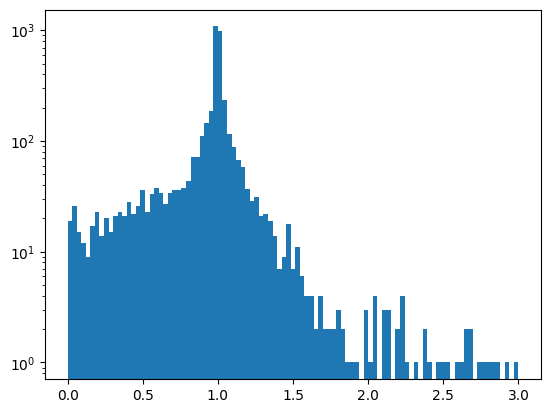

In [86]:
plt.hist(pred_pt/true_pt, bins=np.linspace(0,3,100));
plt.yscale("log")